In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#netCDF4
import netCDF4 as nc
import xarray as xr
#GIS
import warnings
warnings.filterwarnings('ignore')

# Zona de interés

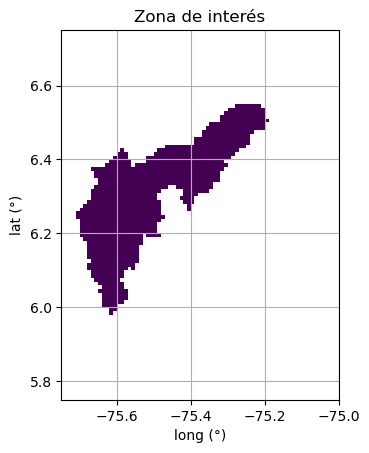

In [2]:
plt.close()
plt.figure()
mask  = np.loadtxt('mask_Aburra.asc', skiprows = 6)
mask_na = np.where(mask == -999, np.nan, mask)
plt.imshow(mask_na, extent=(-75.75,-75, 5.75, 6.75))
plt.title('Zona de interés')
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()
plt.show()

# DEM Zona

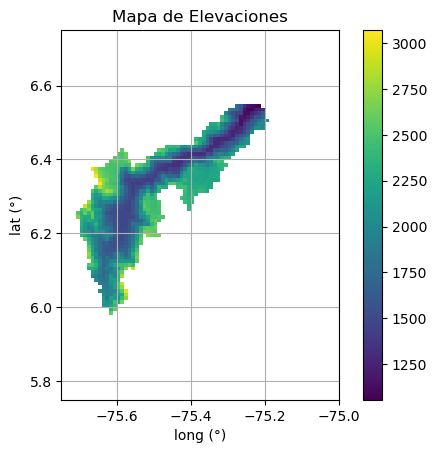

In [4]:
dem  = np.loadtxt('DEM_AburraASC.asc', skiprows = 5)
dem = np.where(mask == -999, np.nan, dem)

plt.close('DEM')
plt.figure('DEM')
plt.imshow(dem, extent=(-75.75,-75, 5.75, 6.75))
plt.title('Mapa de Elevaciones')
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()
plt.colorbar()
plt.show()

El dem de la zona lo concatenamos a si mismo 122 veces, es decir la cantidad de días a usar

In [5]:
#Lo multiplicamos para hacer coincidir con demás variables
dem_arr = []
for i in range(122):
    dem_arr.append(dem)

#volviendo vector
dem_vect=np.concatenate(np.concatenate(dem_arr))
print(len(dem_vect))
dem_vect=dem_vect[~np.isnan(dem_vect)]
print(len(dem_vect))

915000
120048


Se guarda la variable elevación

In [293]:
#Guardar Elevación Vector
(pd.DataFrame(zip(dem_vect),columns=['Elevación'])).to_csv('VariablesListas/Elevacion_Vector.csv', index=False)

# Lectura datos, satélite SIATA

Se cuenca con dados de reflectividad horizontal (dBZ) que deben ser transformados a precipitación

Se hace uso de la librería os para conocer el nombre de cada una de las carpetas a leer. Se cuenta con una carpeta por día.

In [7]:
import os

# folder path
dir_fold = 'D:/UNAL/MachineLearning/DatosRadarSIATA/DatosRadarNC'

# list to store Folders
folder = []

# Iterate directory
for path in os.listdir(dir_fold):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        folder.append(path)

folder = folder[2799:2921]
print('Se toman los datos desde '+folder[0]+' hasta '+folder[-1])

Se toman los datos desde 20200901 hasta 20201231
['202009010210_01_120_cobertura_Reflectivity.nc', '202009010215_01_120_cobertura_Reflectivity.nc', '202009010220_01_120_cobertura_Reflectivity.nc']


Armando la dirección como se muestra a continuación y haciendo uso de la función Multifile de Xarray es posible leer y ensamblar cada uno de los archivos contenidos dentro de cada fecha, archivos que representan 5 minutos de registros.

Notese que cada conjunto de datos diarios queda con un peso de entre 3 a 8 GB.

In [4]:
dir_fold+'/'+folder[29]+'/*.nc'

'D:/UNAL/MachineLearning/DatosRadarSIATA/DatosRadarNC/20200930/*.nc'

In [8]:
xr.open_mfdataset(dir_fold+'/'+folder[3]+'/*.nc', parallel=False)

<xarray.Dataset>
Dimensions:       (time: 272, lat: 1728, lon: 1728)
Coordinates:
  * time          (time) datetime64[ns] 2020-09-04T00:05:00 ... 2020-09-04T23...
  * lat           (lat) float32 4.9 4.902 4.903 4.905 ... 7.486 7.488 7.489 7.49
  * lon           (lon) float32 -76.82 -76.82 -76.82 ... -74.23 -74.23 -74.23
Data variables:
    Reflectivity  (time, lat, lon) float32 dask.array<chunksize=(1, 1728, 1728), meta=np.ndarray>

In [ ]:
for i in range(3,4):
    gridx = np.arange(-75.75,-75, 0.01, dtype='float32')
    gridy = np.arange(6.75, 5.75, -0.01, dtype='float32')
    #Abrir data
    refl = xr.open_mfdataset(dir_fold+'/'+folder[i]+'/*.nc', parallel=False)
    #Reducir área
    refl_clip = refl.sel(lon=slice(-75.75, -75), lat=slice(5.75, 6.75))
    #Transformar reflectividad en precipitación
    ppt_clip = (10**(refl_clip/10)/250)**(1/1.2)
    #Remuestrear de 5 min a Día
    ppt_tinypix_day = ppt_clip.resample(time='1D').sum()
    #Igualar tamaño de pixel deseado
    ppt_day_i = ppt_tinypix_day.reindex(lon=gridx, lat=gridy, method='nearest')
    #Guardar archivo NC
    ppt_day_i.to_netcdf('D:/UNAL/MachineLearning/DatosRadarSIATA/DatosDiariosNC/'+'YaEsPpt_'+folder[i]+'.nc')
    del(refl, refl_clip, ppt_clip, ppt_tinypix_day, ppt_day_i)

Se crea un ciclo donde para cada día se leen los datos, se corta el rectángulo de interés, se transforma la ecuación de reflectividad a precipitación, se cambia la temporalidad a diaria haciendo una suma de las precipitaciones obtenidas y se cambia la resolición a la deseada de 0.01°. Finalmente el archivo creado se almacena.

La ecuación para transformar reflectividad horizontal (dBZ) en precipitación es la siguiente:

$Z = 250 \cdot R^{1.2} \hspace{10pt} \land \hspace{10pt} Z = 10^{dBZ/10}$

en la cual Z tiene unidades de (mm6 m−3) y R es la escorrentia en (mm hr−1)


In [ ]:
for i in range(39,len(folder)):
    gridx = np.arange(-75.75,-75, 0.01, dtype='float32')
    gridy = np.arange(6.75, 5.75, -0.01, dtype='float32')
    #Abrir data
    refl = xr.open_mfdataset(dir_fold+'/'+folder[i]+'/*.nc', parallel=False)
    #Reducir área
    refl_clip = refl.sel(lon=slice(-75.75, -75), lat=slice(5.75, 6.75))
    #Transformar reflectividad en precipitación
    ppt_clip = (10**(refl_clip/10)/250)**(1/1.2)
    #Remuestrear de 5 min a Día
    ppt_tinypix_day = ppt_clip.resample(time='1D').sum()
    #Igualar tamaño de pixel deseado
    ppt_day_i = ppt_tinypix_day.reindex(lon=gridx, lat=gridy, method='nearest')
    #Guardar archivo NC
    ppt_day_i.to_netcdf('D:/UNAL/MachineLearning/DatosRadarSIATA/DatosDiariosNC/'+'YaEsPpt_'+folder[i]+'.nc')
    del(refl, refl_clip, ppt_clip, ppt_tinypix_day, ppt_day_i)

Los archivos recientemente creados se leen nuevamente haciendo uso de multifile. Notandose que este nuevo conjunto de datos es significativamente más liviano.


In [4]:
ppt_day_SIATA = xr.open_mfdataset('D:/UNAL/MachineLearning/DatosRadarSIATA/DatosDiariosNC'+'/*.nc', parallel=False)

ppt_day_SIATA = ppt_day_SIATA/12

In [5]:
np.mean(ppt_day_SIATA['Reflectivity']).values

array(4.7319436, dtype=float32)

In [8]:
#Recortar mascara
ppt_day_siata_ncval = ppt_day_SIATA['Reflectivity'][:].values
ppt_day_siata_arr = []

for i in range(len(ppt_day_siata_ncval)):
    m = np.where(mask == -999, np.nan, ppt_day_siata_ncval[i])
    ppt_day_siata_arr.append(m)

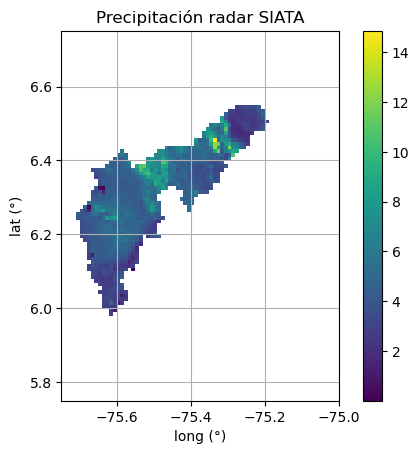

In [18]:
#Grafico
plt.close('chao')
plt.figure('chao')
plt.imshow(ppt_day_siata_arr[3], extent=(-75.75,-75, 5.75, 6.75))
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.gca().set_aspect('equal')
plt.title("Precipitación radar SIATA")
plt.colorbar()
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()
plt.show('chao') 

In [16]:
ppt_day_siata_vect[-10:]

array([ 3.397174 ,  0.4697256,  2.9470413,  1.0565251,  1.3259641,
        2.2272239,  1.3406645,  9.6222105,  2.7059593, 15.341826 ],
      dtype=float32)

In [15]:
#volviendo vector

ppt_day_siata_vect = np.concatenate(np.concatenate(ppt_day_siata_arr))
print(len(ppt_day_siata_vect))
ppt_day_siata_vect=ppt_day_siata_vect[~np.isnan(ppt_day_siata_vect)]
print(len(ppt_day_siata_vect))

915000
120048


In [162]:
np.mean(ppt_day_siata_vect)

2.8547854

In [161]:
#Guardar Precipitación SIATA
(pd.DataFrame(zip(ppt_day_siata_vect),columns=['Ppt_SIATA'])).to_csv('VariablesListas/PptSIATA_Vector.csv', index=False)

# Datos Meteorológicos

## Coordenadas de estaciones

In [3]:
coord = pd.read_csv("Estaciones_Meteorologicas.csv", ",", usecols=['Codigo', 'Longitud', 'Latitud'],encoding='cp1252')
coord = coord.set_index('Codigo')
coord

,Longitud,Latitud
Codigo,,
1,-75.62820,6.22260
2,-75.64069,6.18686
3,-75.69426,6.23309
4,-75.69080,6.34309
5,-75.49214,6.20621
...,...,...
100693,-75.58590,6.31040
100694,-75.54920,6.23000
100695,-75.43522,6.42450


## Datos de Humedad

In [4]:
import os

# folder path
dir_path = r'D:\UNAL\MachineLearning\EstacionesMeteorlog\HumedadAburraNC'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
print(res[:10])

['estacion_data_humedad_1019_20170801_20170831.nc', 'estacion_data_humedad_1019_20171201_20171231.nc', 'estacion_data_humedad_1019_20180101_20180131.nc', 'estacion_data_humedad_1019_20180201_20180228.nc', 'estacion_data_humedad_1019_20180301_20180331.nc', 'estacion_data_humedad_1019_20180601_20180630.nc', 'estacion_data_humedad_1019_20180701_20180731.nc', 'estacion_data_humedad_1019_20180801_20180831.nc', 'estacion_data_humedad_1019_20180901_20180930.nc', 'estacion_data_humedad_1019_20181001_20181031.nc']


In [5]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\HumedadAburraNC\\'
hum1 = xr.open_dataset(path+res[960])
hum1

<xarray.Dataset>
Dimensions:     (date: 35160, quality: 35160, humidity: 35160)
Dimensions without coordinates: date, quality, humidity
Data variables:
    fecha_hora  (date) datetime64[ns] ...
    calidad     (quality) int32 ...
    humedad     (humidity) float64 ...
Attributes:
    description:  Archivo CDF humedad estacion 368
    history:      Created Mon Nov 11 22:54:01 2019
    source:       siata.gov.co

In [6]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\HumedadAburraNC\\'

dfprueba = pd.DataFrame()

# hum_0 = xr.open_dataset(path+res[145])
# df1 = pd.DataFrame(hum_0['humedad'][:].values, columns=[res[0].split('_')[3]], index = hum_0['fecha_hora'][:].values)

for i in range(len(res)):
    #if res[i].split('_')[3] != res[i-1].split('_')[3]:+
    hum1 = xr.open_dataset(path+res[i])
    if len(hum1.dims)==0:
        continue
    elif hum1.dims['date'] == 0:
        continue
    else:
        df1 = pd.DataFrame(hum1['humedad'][:].values, columns=[res[i].split('_')[3]], index = hum1['fecha_hora'][:].values)
        dfprueba = pd.concat([dfprueba, df1])
        if i%50 == 0:
            dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

In [7]:
dejar=[]
for i in range(len(dfprueba)):
    if len(dfprueba.iloc[i].isna().unique()) == 1 and dfprueba.iloc[i].isna().unique()[0]==False:
        dejar.append(i)
df_hum = dfprueba.iloc[dejar]

In [8]:
#datos de humedad meses a utilizar
inter= dfprueba.iloc[dejar].index
intervalo = [inter[0],inter[-1]]
df_4meses = dfprueba.loc[intervalo[0]:intervalo[1]]
df_4meses[df_4meses < 0] = np.nan
#coordenadas de estaciones usadas
long_x = []
lat_y = []

for est in df_hum.keys():
    long_x.append(coord.loc[int(est)][0])
    lat_y.append(coord.loc[int(est)][1])

use_coor = pd.DataFrame([long_x,lat_y],index=['long_x','lat_y'], columns = df_4meses.keys())

### Guardar datos a usar

In [110]:
df_4meses.to_csv('humedad_EstacionesTierra_SIATA.csv')

### Interpolación (Pykrige)

In [9]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [10]:
hum_krig_day_arr = []
for i in range(len(df_4meses)):
    no_nan = ~df_4meses.iloc[i].isna()
    val = df_4meses.iloc[i][no_nan]
    long_x = use_coor.iloc[0][no_nan]
    lat_y = use_coor.iloc[1][no_nan]
    
    #Crea variograma en base a los datos
    OK = OrdinaryKriging(
        long_x, 
        lat_y, 
        val, 
        variogram_model='gaussian',
        verbose=False,
        enable_plotting=False,
        nlags=3,
    )
    
    #Ejecuta Kriging
    gridx = np.arange(-75.75,-75, 0.01, dtype='float64')
    gridy = np.arange(6.75, 5.75, -0.01, dtype='float64')
    zstar, ss = OK.execute("grid", gridx, gridy)
    
    #Cortar zona de interés
    kriging_cut = np.where(mask == -999, np.nan, zstar)
    hum_krig_day_arr.append(kriging_cut)

#### Para ver una sola fecha

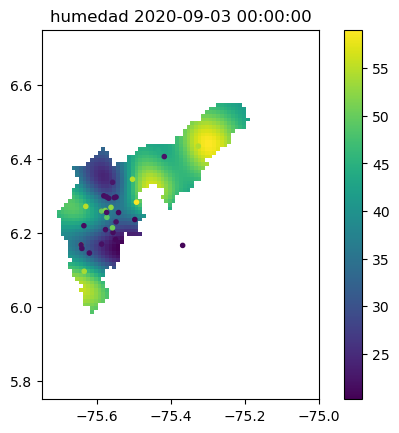

In [11]:
# Para ver una sola fecha
plt.close()
n=2
plt.figure('humedad '+str(inter[n]))
cax = plt.imshow(hum_krig_day_arr[n], extent=(-75.75,-75, 5.75, 6.75))
plt.scatter(use_coor.iloc[0], use_coor.iloc[1], c=df_4meses.iloc[n], marker='.')
cbar=plt.colorbar(cax)
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.title('humedad '+str(inter[n]))
plt.show()

#### Para ver todas las fechas en serie a modo de GIF
*Nota: se quita la primera por que da error de visualización, sin embargo los datos están bien.*

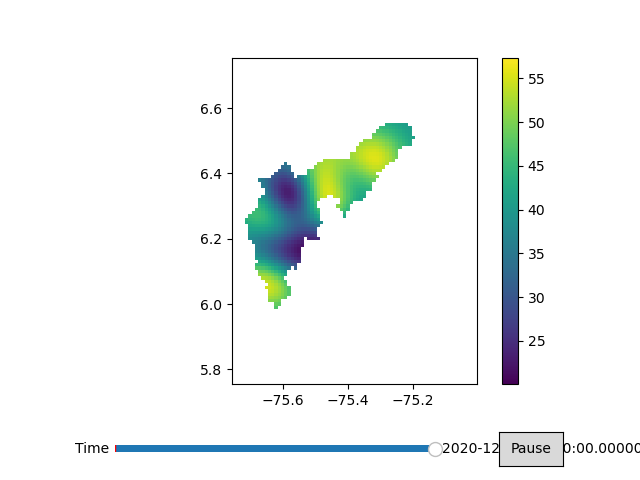

In [11]:
# Paquete para ver gif directamenente en el notebook
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import animatplot as amp


gridx
gridy
t = df_4meses.index[1:]

X, Y, T = np.meshgrid(gridx, gridy, t)

Z = hum_krig_day_arr[1:]

plt.close('humedad multifecha')
plt.figure('humedad multifecha')
block = amp.blocks.Pcolormesh(X[:,:,0], Y[:,:,0], Z, t_axis=2, )#cmap='RdBu')
plt.colorbar(block.quad)
plt.gca().set_aspect('equal')

anim = amp.Animation([block], amp.Timeline(t))

anim.controls()

anim.save_gif('HumedadGIF')
plt.show()

In [260]:
#volviendo vector
hum_krig_day_vect=np.concatenate(np.concatenate(hum_krig_day_arr))
print(len(hum_krig_day_vect))
hum_krig_day_vect=hum_krig_day_vect[~np.isnan(hum_krig_day_vect)]
print(len(hum_krig_day_vect))

915000
120048


In [261]:
#Guardar Humedad Vector
(pd.DataFrame(zip(hum_krig_day_vect),columns=['Humedad'])).to_csv('VariablesListas/HumedadDiaria_Vector.csv', index=False)

## Datos Temperatura

In [13]:
import os

# folder path
dir_path = r'D:\UNAL\MachineLearning\EstacionesMeteorlog\TemperaturaAburraNC'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
print(res[:10])

['estacion_data_temperatura_1019_20170801_20170831.nc', 'estacion_data_temperatura_1019_20171201_20171231.nc', 'estacion_data_temperatura_1019_20180101_20180131.nc', 'estacion_data_temperatura_1019_20180201_20180228.nc', 'estacion_data_temperatura_1019_20180301_20180331.nc', 'estacion_data_temperatura_1019_20200701_20200731.nc', 'estacion_data_temperatura_1019_20200801_20200831.nc', 'estacion_data_temperatura_1019_20200901_20200930.nc', 'estacion_data_temperatura_1019_20201001_20201031.nc', 'estacion_data_temperatura_105_20140101_20140131.nc']


In [14]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\TemperaturaAburraNC\\'
tem1 = xr.open_dataset(path+res[960])
tem1

<xarray.Dataset>
Dimensions:      (date: 43200, quality: 43200, temperature: 43200)
Dimensions without coordinates: date, quality, temperature
Data variables:
    fecha_hora   (date) datetime64[ns] ...
    calidad      (quality) int32 ...
    temperatura  (temperature) float64 ...
Attributes:
    description:  Archivo CDF temperatura estacion 73
    history:      Created Sat Dec 21 06:03:09 2019
    source:       siata.gov.co

In [15]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\TemperaturaAburraNC\\'

dfprueba = pd.DataFrame()

for i in range(len(res)):
    tem1 = xr.open_dataset(path+res[i])
    if len(tem1.dims)==0:
        continue
    elif tem1.dims['date'] == 0:
        continue
    else:
        df1 = pd.DataFrame(tem1['temperatura'][:].values, columns=[res[i].split('_')[3]], index = tem1['fecha_hora'][:].values)
        dfprueba = pd.concat([dfprueba, df1])
        if i%50 == 0:
            dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

In [16]:
# #datos de humedad meses a utilizar
# inter= dfprueba.iloc[dejar].index
# intervalo = [inter[0],inter[-1]]
df_4meses = dfprueba.loc[intervalo[0]:intervalo[1]]
df_4meses[df_4meses < 0] = np.nan

#coordenadas de estaciones usadas
long_x = []
lat_y = []

for est in df_4meses.keys():
    long_x.append(coord.loc[int(est)][0])
    lat_y.append(coord.loc[int(est)][1])

use_coor = pd.DataFrame([long_x,lat_y],index=['long_x','lat_y'], columns = df_4meses.keys())

### Interpolación (Pykrige)

In [17]:
temp_krig_day_arr = []

gridx = np.arange(-75.75,-75, 0.01, dtype='float64')
gridy = np.arange(6.75, 5.75, -0.01, dtype='float64')
lonX, latY = np.meshgrid(gridx, gridy)

for i in range(len(df_4meses)):
    no_nan = ~df_4meses.iloc[i].isna()
    val = df_4meses.iloc[i][no_nan]
    long_x = use_coor.iloc[0][no_nan]
    lat_y = use_coor.iloc[1][no_nan]
    
    #Crea variograma en base a los datos
    OK = OrdinaryKriging(
        long_x, 
        lat_y, 
        val, 
        variogram_model='gaussian',
        verbose=False,
        enable_plotting=False,
        nlags=3,
    )
    
    #Ejecuta Kriging
    gridx = np.arange(-75.75,-75, 0.01, dtype='float64')
    gridy = np.arange(6.75, 5.75, -0.01, dtype='float64')
    zstar, ss = OK.execute("grid", gridx, gridy)
    
    #Cortar zona de interés
    kriging_cut = np.where(mask == -999, np.nan, zstar)
    temp_krig_day_arr.append(kriging_cut)

#### Para ver una sola fecha

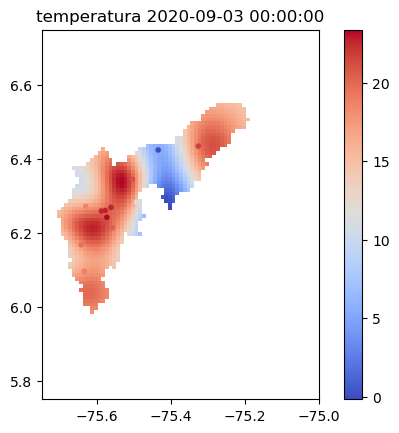

In [21]:
# Para ver una sola fecha
plt.close()
n=2
plt.figure('temperatura '+str(inter[n]))
cmap = 'coolwarm'
cax = plt.imshow(temp_krig_day_arr[n], extent=(-75.75,-75, 5.75, 6.75),cmap=cmap)
plt.scatter(use_coor.iloc[0], use_coor.iloc[1], c=df_4meses.iloc[n], marker='.',cmap=cmap)
cbar=plt.colorbar(cax)
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.title('temperatura '+str(inter[n]))
plt.show()

#### Para ver todas las fechas en serie a modo de GIF

In [18]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import animatplot as amp


gridx
gridy
t = df_4meses.index

X, Y, T = np.meshgrid(gridx, gridy, t)

Z = temp_krig_day_arr

cmap = matplotlib.cm.get_cmap('coolwarm')
plt.close('temperatura multifecha')
plt.figure('temperatura multifecha')
block = amp.blocks.Pcolormesh(X[:,:,0], Y[:,:,0], Z, t_axis=2, cmap=cmap)
plt.colorbar(block.quad)
plt.gca().set_aspect('equal')
plt.title('Temperatura')
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()

anim = amp.Animation([block], amp.Timeline(t))

anim.controls()

anim.save_gif('TemperaturaGIF')
plt.show()

NameError: name 'matplotlib' is not defined

In [96]:
#volviendo vector
temp_krig_day_vect=np.concatenate(np.concatenate(temp_krig_day_arr))
print(len(temp_krig_day_vect))
temp_krig_day_vect=temp_krig_day_vect[~np.isnan(temp_krig_day_vect)]
print(len(temp_krig_day_vect))

915000
120048


In [97]:
min(temp_krig_day_vect)

-9.763895723258344

In [78]:
#Guardar Temperatura Vector
(pd.DataFrame(zip(temp_krig_day_vect),columns=['Temperatura'])).to_csv('VariablesListas/TemperaturaDiaria_Vector.csv', index=False)

## Datos Presión

In [22]:
import os

# folder path
dir_path = r'D:\UNAL\MachineLearning\EstacionesMeteorlog\PresionAburraNC'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
print(res[:10])

['estacion_data_presion_1019_20170801_20170831.nc', 'estacion_data_presion_1019_20171201_20171231.nc', 'estacion_data_presion_1019_20180101_20180131.nc', 'estacion_data_presion_1019_20180201_20180228.nc', 'estacion_data_presion_1019_20180301_20180331.nc', 'estacion_data_presion_1019_20200701_20200731.nc', 'estacion_data_presion_1019_20200801_20200831.nc', 'estacion_data_presion_1019_20200901_20200930.nc', 'estacion_data_presion_1019_20201001_20201031.nc', 'estacion_data_presion_105_20140101_20140131.nc']


In [23]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\PresionAburraNC\\'
pres1 = xr.open_dataset(path+res[960])
pres1

<xarray.Dataset>
Dimensions:     (date: 43200, quality: 43200, pressure: 43200)
Dimensions without coordinates: date, quality, pressure
Data variables:
    fecha_hora  (date) datetime64[ns] ...
    calidad     (quality) int32 ...
    presion     (pressure) float64 ...
Attributes:
    description:  Archivo CDF Presion estacion 73
    history:      Created Sat Dec 21 06:03:07 2019
    source:       siata.gov.co

In [24]:
path='D:\\UNAL\\MachineLearning\\EstacionesMeteorlog\\PresionAburraNC\\'

dfprueba = pd.DataFrame()

for i in range(len(res)):
    pres1 = xr.open_dataset(path+res[i])
    if len(pres1.dims)==0:
        continue
    elif pres1.dims['date'] == 0:
        continue
    else:
        df1 = pd.DataFrame(pres1['presion'][:].values, columns=[res[i].split('_')[3]], index = pres1['fecha_hora'][:].values)
        dfprueba = pd.concat([dfprueba, df1])
        if i%50 == 0:
            dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

dfprueba = dfprueba.groupby(pd.Grouper(freq='1D')).mean()

In [25]:
# #datos de humedad meses a utilizar
# inter= dfprueba.iloc[dejar].index
# intervalo = [inter[0],inter[-1]]
df_4meses = dfprueba.loc[intervalo[0]:intervalo[1]]
df_4meses[df_4meses < 0] = np.nan

#coordenadas de estaciones usadas
long_x = []
lat_y = []

for est in df_4meses.keys():
    long_x.append(coord.loc[int(est)][0])
    lat_y.append(coord.loc[int(est)][1])

use_coor = pd.DataFrame([long_x,lat_y],index=['long_x','lat_y'], columns = df_4meses.keys())

### Interpolación (Pykrige)

In [26]:
pres_krig_day_arr = []

gridx = np.arange(-75.75,-75, 0.01, dtype='float64')
gridy = np.arange(6.75, 5.75, -0.01, dtype='float64')
lonX, latY = np.meshgrid(gridx, gridy)

for i in range(len(df_4meses)):
    no_nan = ~df_4meses.iloc[i].isna()
    val = df_4meses.iloc[i][no_nan]
    long_x = use_coor.iloc[0][no_nan]
    lat_y = use_coor.iloc[1][no_nan]
    
    #Crea variograma en base a los datos
    OK = OrdinaryKriging(
        long_x, 
        lat_y, 
        val, 
        variogram_model='gaussian',
        verbose=False,
        enable_plotting=False,
        nlags=3,
    )
    
    #Ejecuta Kriging
    gridx = np.arange(-75.75,-75, 0.01, dtype='float64')
    gridy = np.arange(6.75, 5.75, -0.01, dtype='float64')
    zstar, ss = OK.execute("grid", gridx, gridy)
    
    #Cortar zona de interés
    kriging_cut = np.where(mask == -999, np.nan, zstar)
    pres_krig_day_arr.append(kriging_cut)

#### Para ver una sola fecha

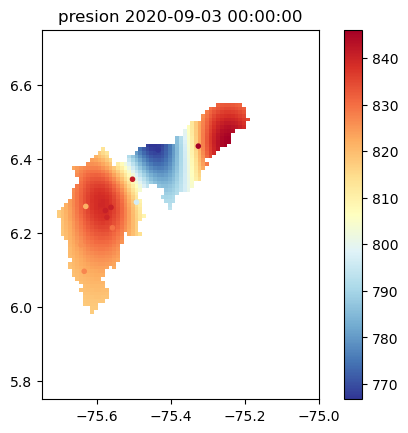

In [31]:
# Para ver una sola fecha
plt.close()
n=2
plt.figure('presion '+str(inter[n]))
cmap = 'RdYlBu_r'
cax = plt.imshow(pres_krig_day_arr[n], extent=(-75.75,-75, 5.75, 6.75),cmap=cmap)
plt.scatter(use_coor.iloc[0], use_coor.iloc[1], c=df_4meses.iloc[n], marker='.',cmap=cmap)
cbar=plt.colorbar(cax)
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.title('presion '+str(inter[n]))
plt.show()

#### Para ver todas las fechas en serie a modo de GIF

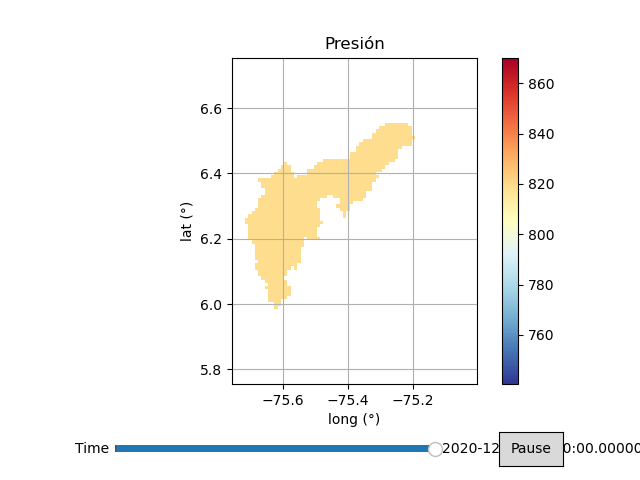

In [42]:
%matplotlib ipympl

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import animatplot as amp


gridx
gridy
t = df_4meses.index

X, Y, T = np.meshgrid(gridx, gridy, t)

Z = pres_krig_day_arr

cmap = matplotlib.cm.get_cmap('RdYlBu_r')
plt.close('presión multifecha')
plt.figure('presión multifecha')
block = amp.blocks.Pcolormesh(X[:,:,0], Y[:,:,0], Z, t_axis=2, cmap=cmap)
plt.colorbar(block.quad)
plt.gca().set_aspect('equal')
plt.title('Presión')
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()

anim = amp.Animation([block], amp.Timeline(t))

anim.controls()

anim.save_gif('PresionGIF')
plt.show()

In [79]:
#volviendo vector
pres_krig_day_vect=np.concatenate(np.concatenate(pres_krig_day_arr))
print(len(pres_krig_day_vect))
pres_krig_day_vect=pres_krig_day_vect[~np.isnan(pres_krig_day_vect)]
print(len(pres_krig_day_vect))

915000
120048


In [81]:
#Guardar Presión Vector
(pd.DataFrame(zip(pres_krig_day_vect),columns=['Presion'])).to_csv('VariablesListas/PresionDiaria_Vector.csv', index=False)

# Precipitación ERA5

## Información horaria a diaria

In [ ]:
ppt_hr = xr.open_dataset('TotalPrecipitation.nc')
ppt_day_era25 = ppt_hr.resample(time='1D').sum()

ppt_day_era25

<xarray.Dataset>
Dimensions:    (time: 2922, longitude: 4, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -75.75 -75.5 -75.25 -75.0
  * latitude   (latitude) float32 6.75 6.5 6.25 6.0 5.75
Data variables:
    tp         (time, latitude, longitude) float32 0.0006072 ... 0.001348

In [ ]:
df_4meses.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=122, freq='D')

In [ ]:
#
gridx = np.arange(-75.75,-75, 0.01, dtype='float32')
gridy = np.arange(6.75, 5.75, -0.01, dtype='float32')
ppt_day_era01 = ppt_day_era25.reindex(longitude=gridx, latitude=gridy, time=df_4meses.index, method='nearest')

ppt_day_era01

<xarray.Dataset>
Dimensions:    (longitude: 75, latitude: 100, time: 122)
Coordinates:
  * longitude  (longitude) float32 -75.75 -75.74 -75.73 ... -75.03 -75.02 -75.01
  * latitude   (latitude) float32 6.75 6.74 6.73 6.72 ... 5.79 5.78 5.77 5.76
  * time       (time) datetime64[ns] 2020-09-01 2020-09-02 ... 2020-12-31
Data variables:
    tp         (time, latitude, longitude) float32 0.01771 0.01771 ... 0.001348

In [ ]:
ppt_day_era01.to_netcdf('Ppt_day_ERA5.nc')

In [27]:
ppt_day_era01 = xr.open_dataset('Ppt_day_ERA5.nc')
ppt_day_era01

<xarray.Dataset>
Dimensions:    (longitude: 75, latitude: 100, time: 122)
Coordinates:
  * longitude  (longitude) float32 -75.75 -75.74 -75.73 ... -75.03 -75.02 -75.01
  * latitude   (latitude) float32 6.75 6.74 6.73 6.72 ... 5.79 5.78 5.77 5.76
  * time       (time) datetime64[ns] 2020-09-01 2020-09-02 ... 2020-12-31
Data variables:
    tp         (time, latitude, longitude) float32 ...

In [28]:
#Recortar mascara
ppt_day_era_ncval = ppt_day_era01['tp'][:].values*1000
ppt_day_era_arr = []

for i in range(len(ppt_day_era_ncval)):
    m = np.where(mask == -999, np.nan, ppt_day_era_ncval[i])
    ppt_day_era_arr.append(m)

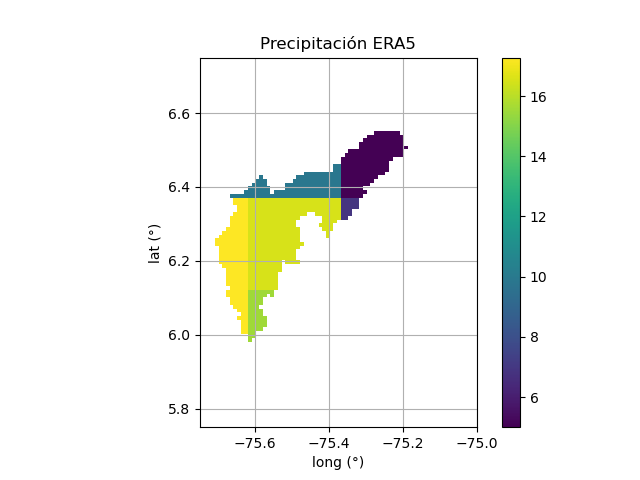

In [41]:
#Grafico
plt.close('chao')
plt.figure('chao')
plt.imshow(ppt_day_era_arr[37], extent=(-75.75,-75, 5.75, 6.75))
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.gca().set_aspect('equal')
plt.title("Precipitación ERA5")
plt.colorbar()
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()
plt.show('chao') 

In [150]:
#volviendo vector

ppt_day_era_vect = np.concatenate(np.concatenate(ppt_day_era_arr))
print(len(ppt_day_era_vect))
ppt_day_era_vect=ppt_day_era_vect[~np.isnan(ppt_day_era_vect)]
print(len(ppt_day_era_vect))

915000
120048


In [152]:
#Guardar Precipitación ERA5
(pd.DataFrame(zip(ppt_day_era_vect),columns=['Ppt_ERA5'])).to_csv('VariablesListas/PptEra5_Vector.csv', index=False)

# Coordenadas como variables

Se hace uso de las variables anteriormente creadas para la generación de los GIF. X, Y.

In [19]:
np.shape(X)

(100, 75, 122)

In [20]:
X[:,:,0]

array([[-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01],
       [-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01],
       [-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01],
       ...,
       [-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01],
       [-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01],
       [-75.75, -75.74, -75.73, ..., -75.03, -75.02, -75.01]])

In [23]:
#Recortar mascara
X_arr = []
Y_arr = []

X_cut = np.where(mask == -999, np.nan, X[:,:,0])
Y_cut = np.where(mask == -999, np.nan, Y[:,:,0])

#Lo multiplicamos para hacer coincidir con demás variables
for i in range(np.shape(X)[2]):
    X_arr.append(X_cut)
    Y_arr.append(Y_cut)

#### Graficando coordenadas X y Y

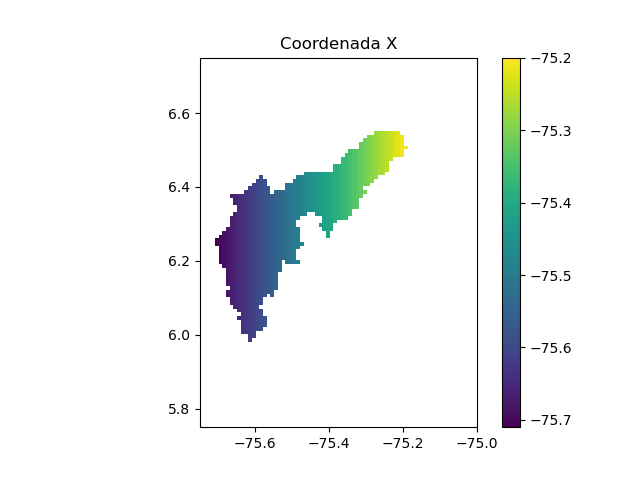

In [25]:
# Para ver una sola fecha
plt.close()
n=0
plt.figure('Coordenada X')
cax = plt.imshow(X_arr[n], extent=(-75.75,-75, 5.75, 6.75))
cbar=plt.colorbar(cax)
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.title('Coordenada X')
plt.show()

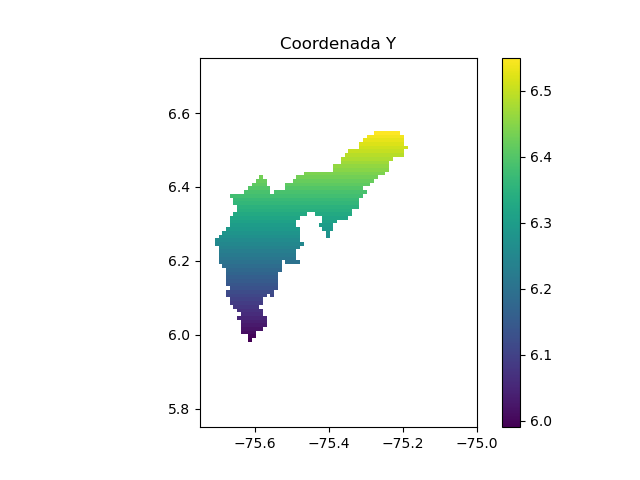

In [26]:
# Para ver una sola fecha
plt.close()
n=0
plt.figure('Coordenada Y')
cax = plt.imshow(Y_arr[n], extent=(-75.75,-75, 5.75, 6.75))
cbar=plt.colorbar(cax)
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.title('Coordenada Y')
plt.show()

In [68]:
#volviendo vector
X_vect=np.concatenate(np.concatenate(X_arr))
Y_vect=np.concatenate(np.concatenate(Y_arr))
print(len(X_vect),', ',len(Y_vect))
#Eliminamos NaN
X_vect=X_vect[~np.isnan(X_vect)]
Y_vect=Y_vect[~np.isnan(Y_vect)]
print(len(X_vect),', ',len(Y_vect))

915000 ,  915000
120048 ,  120048


In [69]:
#Guardar Coordenadas
(pd.DataFrame(zip(X_vect,Y_vect),columns=['CoorX','CoorY'])).to_csv('VariablesListas/Coord_Vector.csv', index=False)